
## Exploring Overfit with Gradient Boosting

#### Berit Hudson Rasmussen
#### Geological Sciences, Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

Overfit occurs when a machine learning model is too complex such that it fits noise in the training data. Overfit model acheive very low error with the training data but very high error with testing data. All machine learning models must strive to avoid overfit through a tradeoff between model bias and variance. One method, Gradient Boosting, avoids overfit by utilizing a learning rate hyperparameter that controls the contribution of each tree, or the size of step towards the solution. However, overfit can still occur with Gradient Boosting and therefore it is important we understand how hyperparameters contribtute to model complexity and error. Here, I aim to explore how overfit can occur with gradient boosting by training a model with different hyperparameter values and analyzing the effects on the training vs testing data error. I found that by using a high learning rate, number of trees, and max depth of tree, I achieved a large mismatch between the training data error (zero) and the testing error. The testing error on my overfit model was ~200% higher than for a different model with more reasonable hyperparameters. It is therefore crucial that hyperparameter tuning is performed when using Gradient Boosting to ensure that optimal results can be obtained while avoiding overfit.

### Import Packages

In [1392]:
import pandas as pd   #dataframes
import matplotlib

import matplotlib.pyplot as plt    #for plotting
import matplotlib.patches as patches #add rectangle to plots
import numpy as np
import math  #for basic math operators
import matplotlib.ticker as ticker # control of axes ticks
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
import random #for random seed generator
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV #for hyperparameter testing
from sklearn.model_selection import train_test_split                #function to split data for training vs testing
from sklearn.metrics import mean_squared_error                  #function to get MSE


from sklearn.ensemble import GradientBoostingRegressor        # tree-based gradient boosting
from sklearn.tree import _tree                                # for accessing tree information


### Functions

The following functions will be used in the workflow.

In [1395]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_Gradient_Boosting.ipynb from GeostatsGuy GitHub.
def add_grid():       #this function adds grid lines to a plot
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [1397]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_Gradient_Boosting.ipynb from GeostatsGuy GitHub.
def visualize_model(model,X1_train,X1_test,X2_train,X2_test,Xmin,Xmax,y_train,y_test,ymin,
                         ymax,title,Xname,yname,Xlabel,ylabel,annotate=True):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    X1plot_step = (Xmax[0] - Xmin[0])/300.0; X2plot_step = -1*(Xmax[1] - Xmin[1])/300.0 # resolution of the model visualization
    XX1, XX2 = np.meshgrid(np.arange(Xmin[0], Xmax[0], X1plot_step), # set up the mesh
                     np.arange(Xmax[1], Xmin[1], X2plot_step))
    y_hat = model.predict(np.c_[XX1.ravel(), XX2.ravel()])    # predict with our trained model over the mesh
    y_hat = y_hat.reshape(XX1.shape)

    plt.imshow(y_hat,interpolation=None, aspect="auto", extent=[Xmin[0],Xmax[0],Xmin[1],Xmax[1]], 
        vmin=ymin,vmax=ymax,alpha = 1.0,cmap=cmap,zorder=1)
    sp = plt.scatter(X1_train,X2_train,s=None, c=y_train, marker='o', cmap=cmap, 
        norm=None, vmin=ymin, vmax=ymax, alpha=0.6, linewidths=0.3, edgecolors="black", label = 'Train',zorder=10)
    plt.scatter(X1_test,X2_test,s=None, c=y_test, marker='s', cmap=cmap, 
        norm=None, vmin=ymin, vmax=ymax, alpha=0.3, linewidths=0.3, edgecolors="black", label = 'Test',zorder=10)
    plt.title(title); plt.xlabel(Xlabel[0]); plt.ylabel(Xlabel[1])
    plt.xlim([Xmin[0],Xmax[0]]); plt.ylim([Xmin[1],Xmax[1]])
    cbar = plt.colorbar(sp, orientation = 'vertical')         # add the color bar
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    cbar.set_label(ylabel, rotation=270, labelpad=20)
    return y_hat

### Load Data

The following workflow applies the .csv file 'unconv_MV_v2.csv', a synthetic dataset. The dataset is publically available here (https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV_v2.csv).  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **Log permeability** - ability of a fluid to flow through the rock in log mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$
* **Brittleness** - tendency to fracture in %
* **Total Organic Carbon** - % of organic carbon in rock
* **Vitrinite Reflectance** - % of light reflected from surface


In [1400]:
my_data = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v2.csv") # load the data file from Dr. Pyrcz's GeoDataSets GitHub repository
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed

In [1402]:
## Visualize Dataset
my_data.head()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919


### 1. Prepare Dataset

1a. Define the response and predictor features

In [1406]:
response='Production' #response feature 
resp_name = 'Production (90 day monthly average MCFPD)' #name for plot labels
predictors = ['Por','LogPerm','AI','Brittle','TOC','VR'] # all other features will be used to predict production
pred_names = ['Porosity (%)','Log Permeability (miliDarcy)','Acoustic Impedance (kg/m2s*10^6)','Brittleness (%)','Total Organic Carbon (%)','Vitrinite Ratio (%)']

1b. Add noise to the response feature

In [1409]:
std_error = 1000  # standard deviation of random error
np.random.seed(seed=13)                                 # set random number seed
my_data[response] = my_data[response] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data)) # add noise, from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Gradient_Boosting.ipynb


1c. Check feature ranges

We'll look at some histograms of all our predictor feautures:

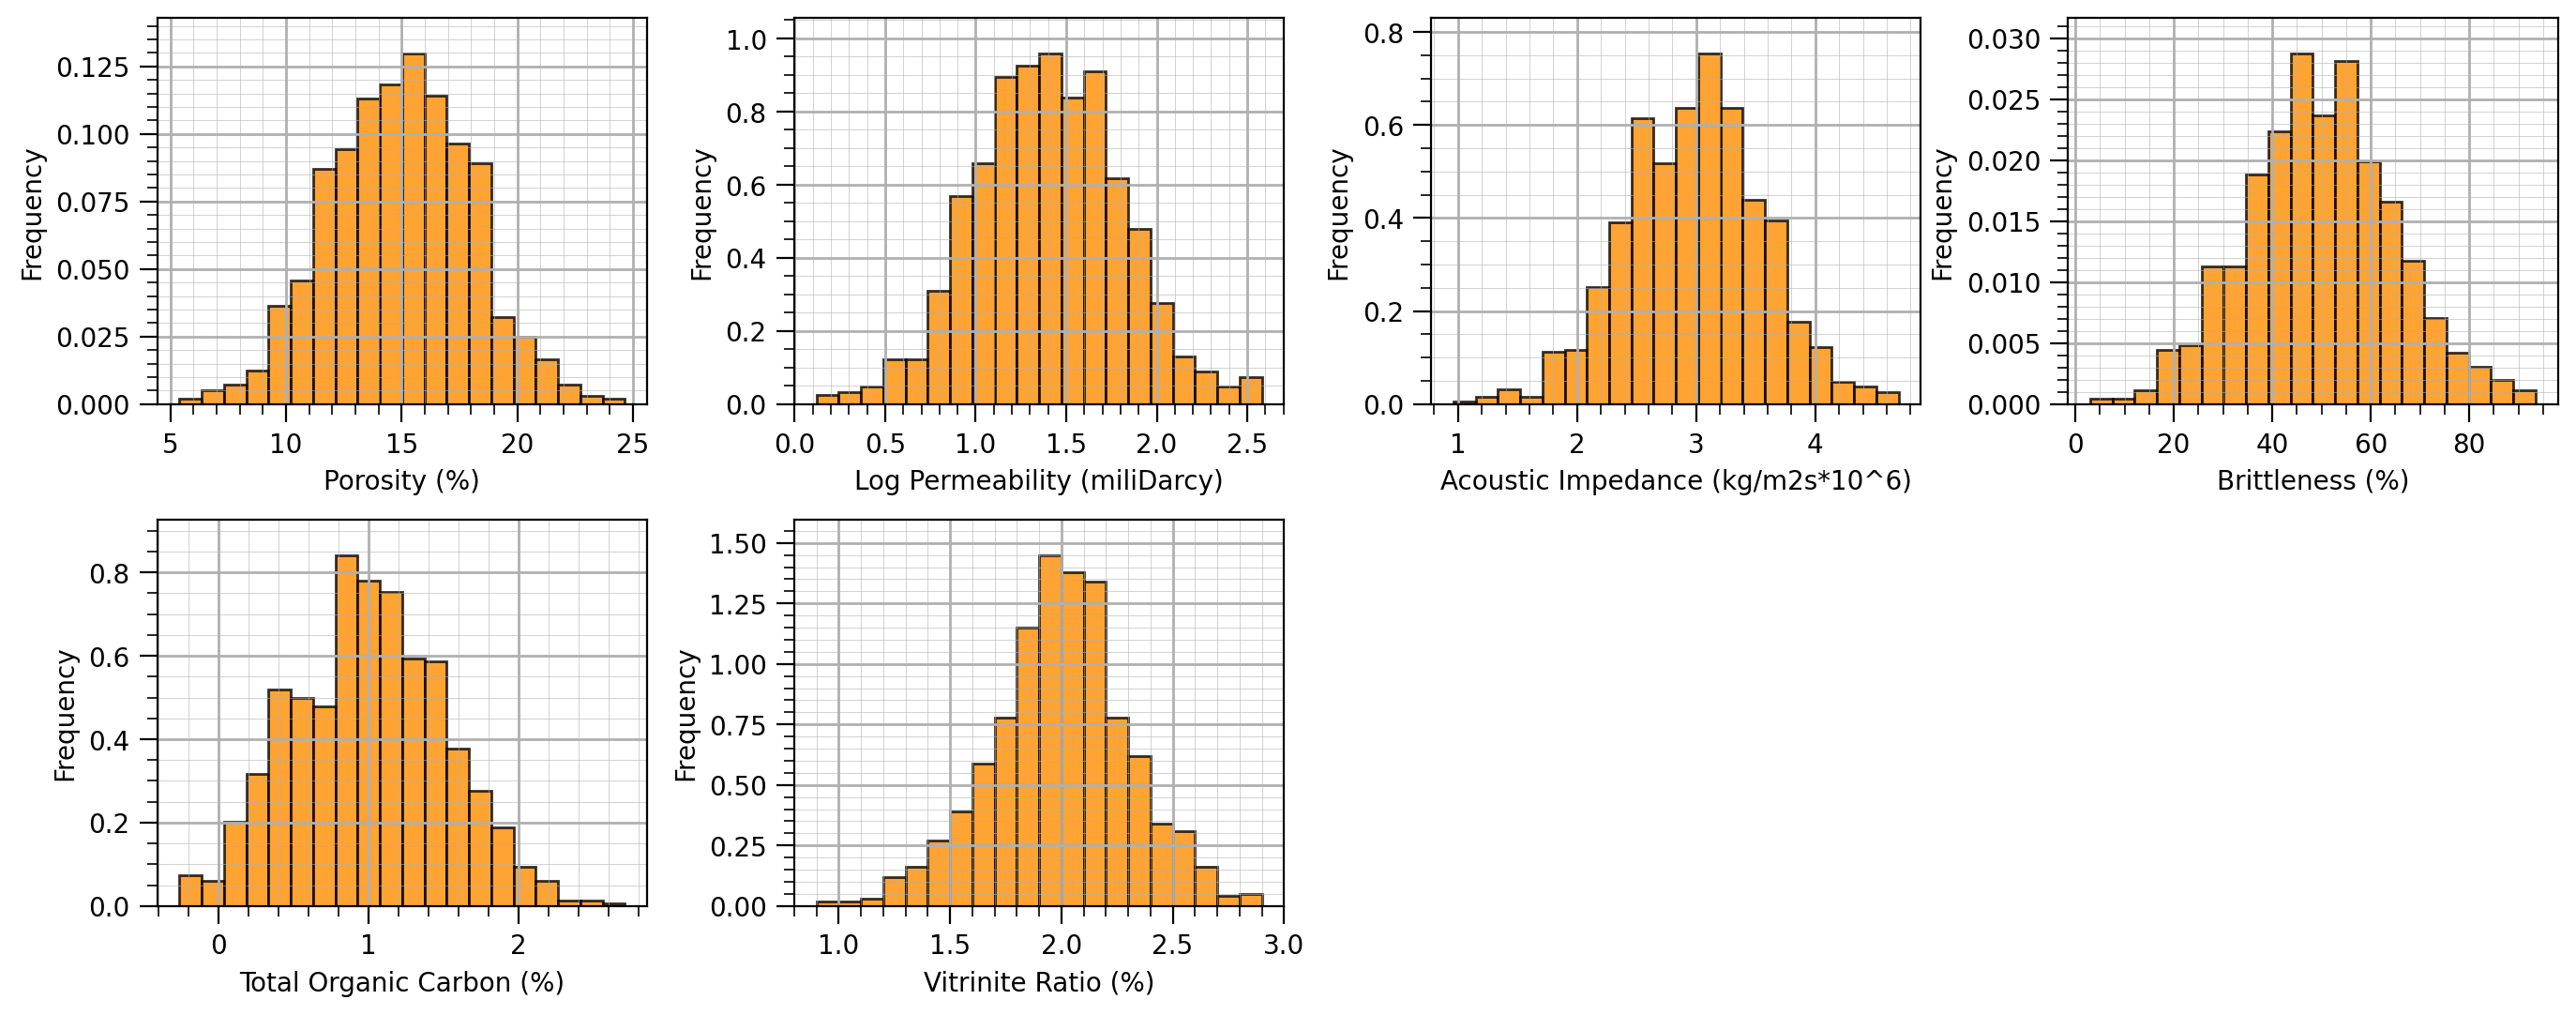

In [1413]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_Gradient_Boosting.ipynb from GeostatsGuy GitHub.

nbins = 20
                                    # number of histogram bins
for i, feature in enumerate(predictors):                        # plot histograms 
    plt.subplot(4,4,i+1)
    y,_,_ = plt.hist(x=my_data[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True) #change burned/unburned
    plt.xlabel(pred_names[i]); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.3, hspace=0.3); plt.show()

There are some negative values for TOC, which can't be correct, so we will truncate the dataset:

In [1416]:
#from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Gradient_Boosting.ipynb
num = my_data._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0
my_data.describe().transpose()                              # calculate summary statistics for the data


,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.40,12.857500,14.985000,17.080000,24.650000
LogPerm,1000.0,1.398880,0.405966,0.12,1.130000,1.390000,1.680000,2.580000
AI,1000.0,2.982610,0.577629,0.96,2.577500,3.010000,3.360000,4.700000
Brittle,1000.0,49.769980,14.944955,3.03,39.722500,49.680000,59.170000,93.470000
TOC,1000.0,1.006170,0.499838,0.00,0.640000,0.995000,1.360000,2.710000
VR,1000.0,1.991170,0.308194,0.90,1.810000,2.000000,2.172500,2.900000
Production,1000.0,2272.539559,1679.732304,0.00,956.454815,2052.085042,3283.174143,13561.203887


Now we see that the min value for TOC is 0, so we're good to go.

1d. Finally, we make dataframes for the predictors and the response feature: 

In [1420]:
y = my_data[response] #This is a dataframe of just the response feature

X = my_data[predictors] #This is a dataframe of just the predictor features

### 2. Train/Test Split

In order to train the model, we perform a train/test split where we withhold a certain percentage of data (usually ~10-30%) for testing. This data is set aside and not used at all to train the model. The model is fit using the training data and then the testing data can be used to evaluate the performance of the model.

2a. Perform split 

In [1425]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=73073) # train and test split

df_train = pd.concat([X_train,y_train],axis=1)                # make one train DataFrame with both X and y
df_test = pd.concat([X_test,y_test],axis=1)                   # make one test DataFrame with both X and y

X_train now represents our training data, with y_train representing the response to check our model as we train.
X_test is the withheld data for testing and y_test the withheld response to evaluate model performance.

2b. Visualize the split

We will plot the testing and training data on overlapping histograms to ensure our split worked.

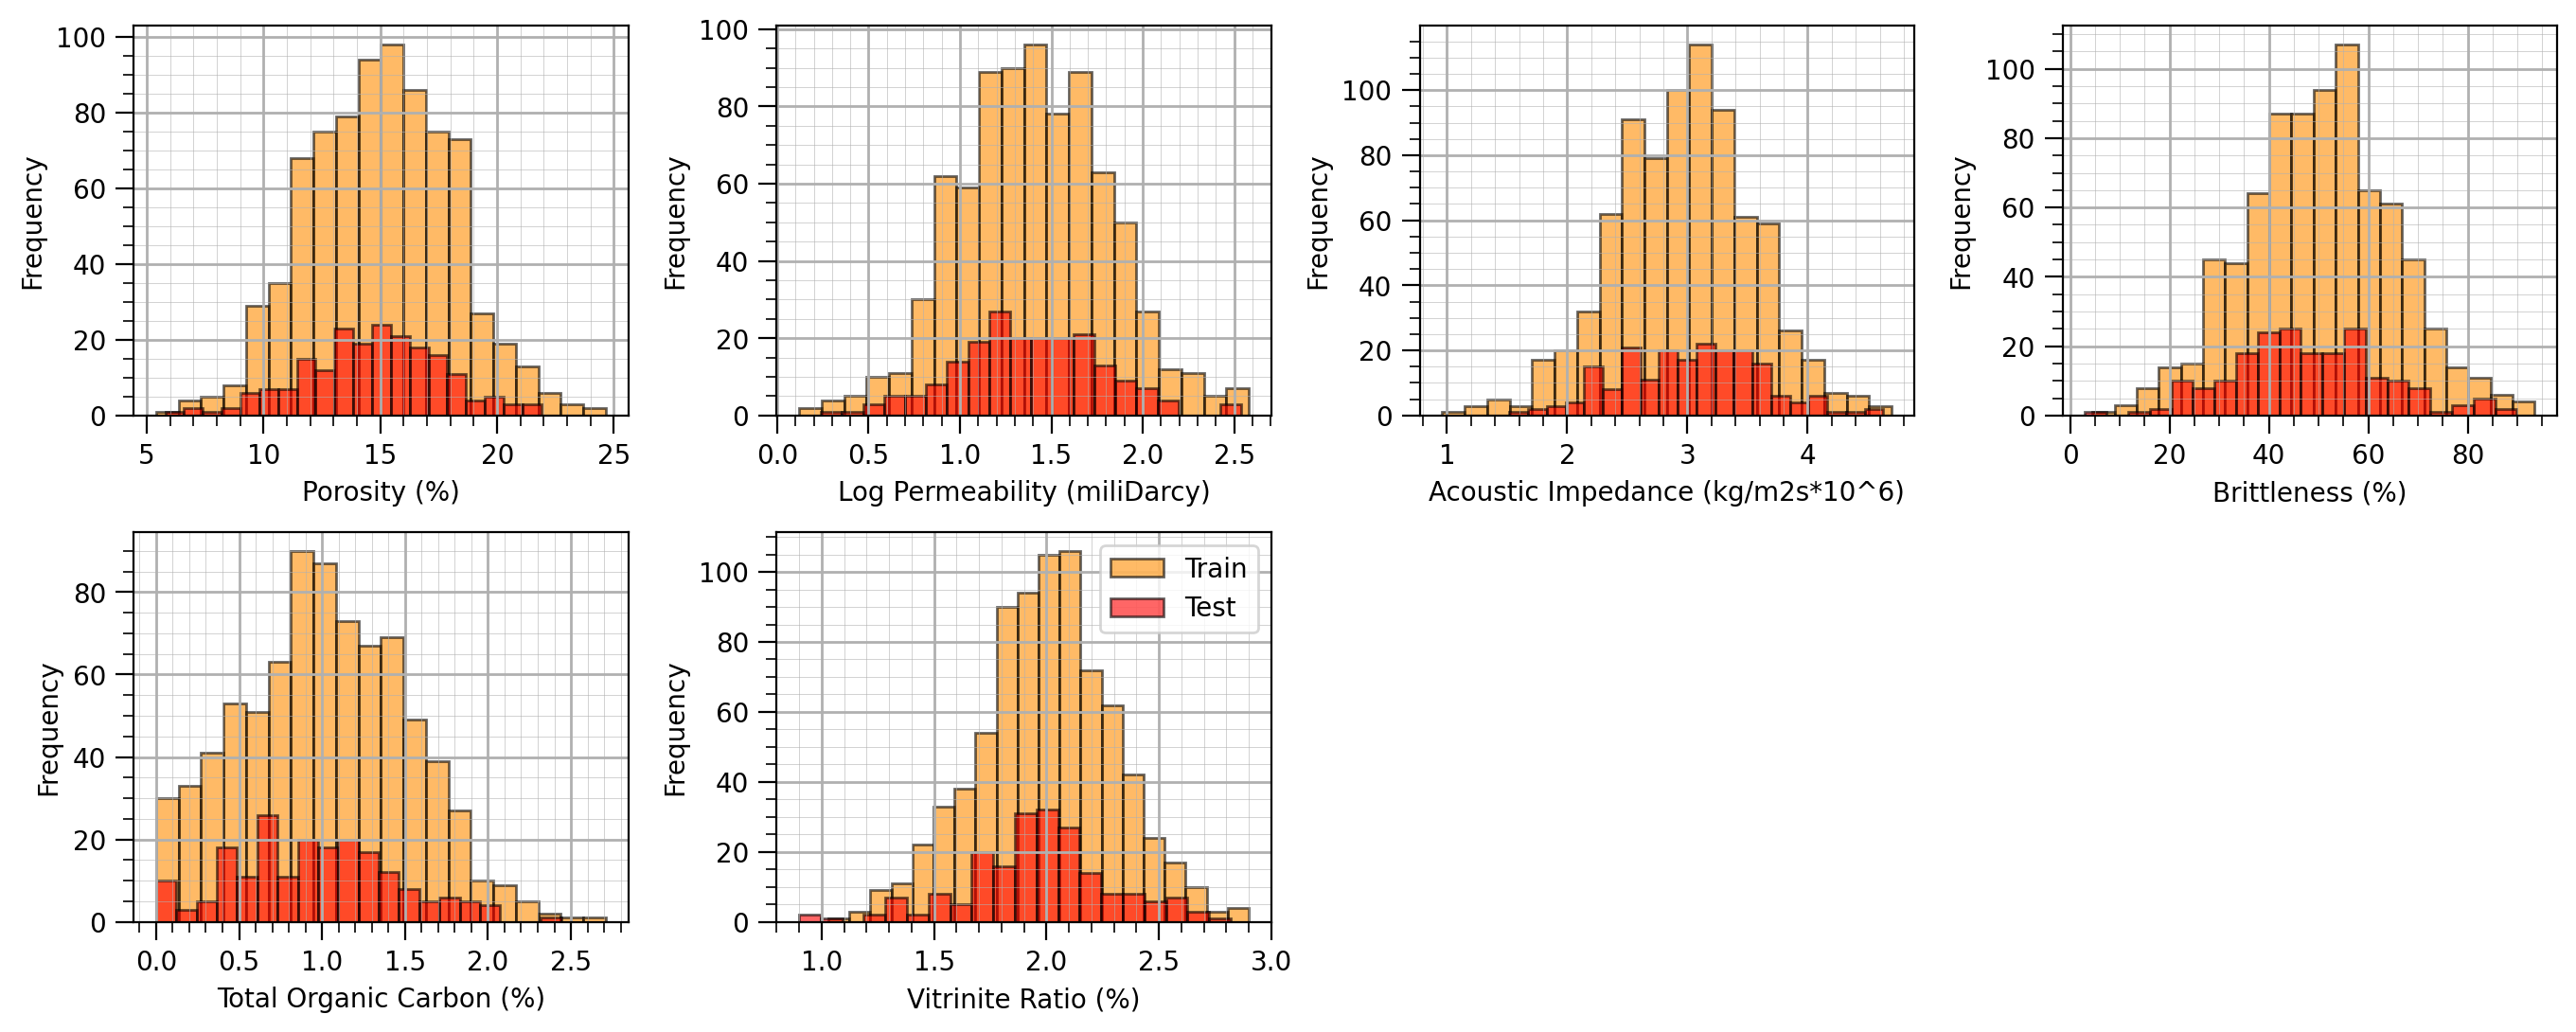

In [1541]:
nbins = 20                                                    # number of histogram bins
for i, feature in enumerate(predictors):                        # plot histograms with central tendency and P10 and P90 labeled
    plt.subplot(4,4,i+1)
    y,_,_ = plt.hist(x=df_train[feature],weights=None,bins=nbins,alpha = 0.6,edgecolor='black',color='darkorange',density=False,label='Train') 
    y,_,_ = plt.hist(x=df_test[feature],weights=None,bins=nbins,alpha = 0.6,edgecolor='black',color='red',density=False, label='Test') 

    plt.xlabel(pred_names[i]); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.3, hspace=0.3); plt.legend(loc='upper right') ;plt.show()

Here we can see that the train and test datasets look good. The test data is contained within the train data and the shape of distributions look similar.

### 3. Example of Gradient Boosting

3a. Set Hyperparameters

Loss: L1 or L2 norm loss function used to evaluate model performance

n_estimaters: number of trees used, which are averaged together

max_depth: how deep each tree can be

learning_rate: how much information is gained from each tree

In [1469]:
params = {
    'loss': 'squared_error',                                 # L2 Norm - least squares
    'n_estimators': 50,                                      # number of trees
    'max_depth': 3,                                         # maximum depth per tree
    'learning_rate': 0.15,  
}

3b. Instatiate the model using the above hyperparameters

In [1472]:
test_model = GradientBoostingRegressor(**params) #test_model is now our Gradient Boosting model with the above hyperparameters

3c. Fit the model to the training data

In [1475]:
test_model.fit(X = X_train, y = y_train) #fit model to training data

GradientBoostingRegressor(learning_rate=0.15, n_estimators=50)

We can check how well the model predicts the training data vs the testing data:

In [1478]:
print("Training Accuracy:", test_model.score(X_train, y_train))
print("Testing Accuracy:", test_model.score(X_test, y_test))



Training Accuracy: 0.7907628843991172
Testing Accuracy: 0.5607166306638078


3d. Predict the response feature using the testing data

In [1481]:
ypred = test_model.predict(X_test)

3e. Visualize results

Let's plot the true data vs the estimated data using our first gradient boosting model:

Text(0.5, 0, 'True Production (kg/m2s*10^6)')

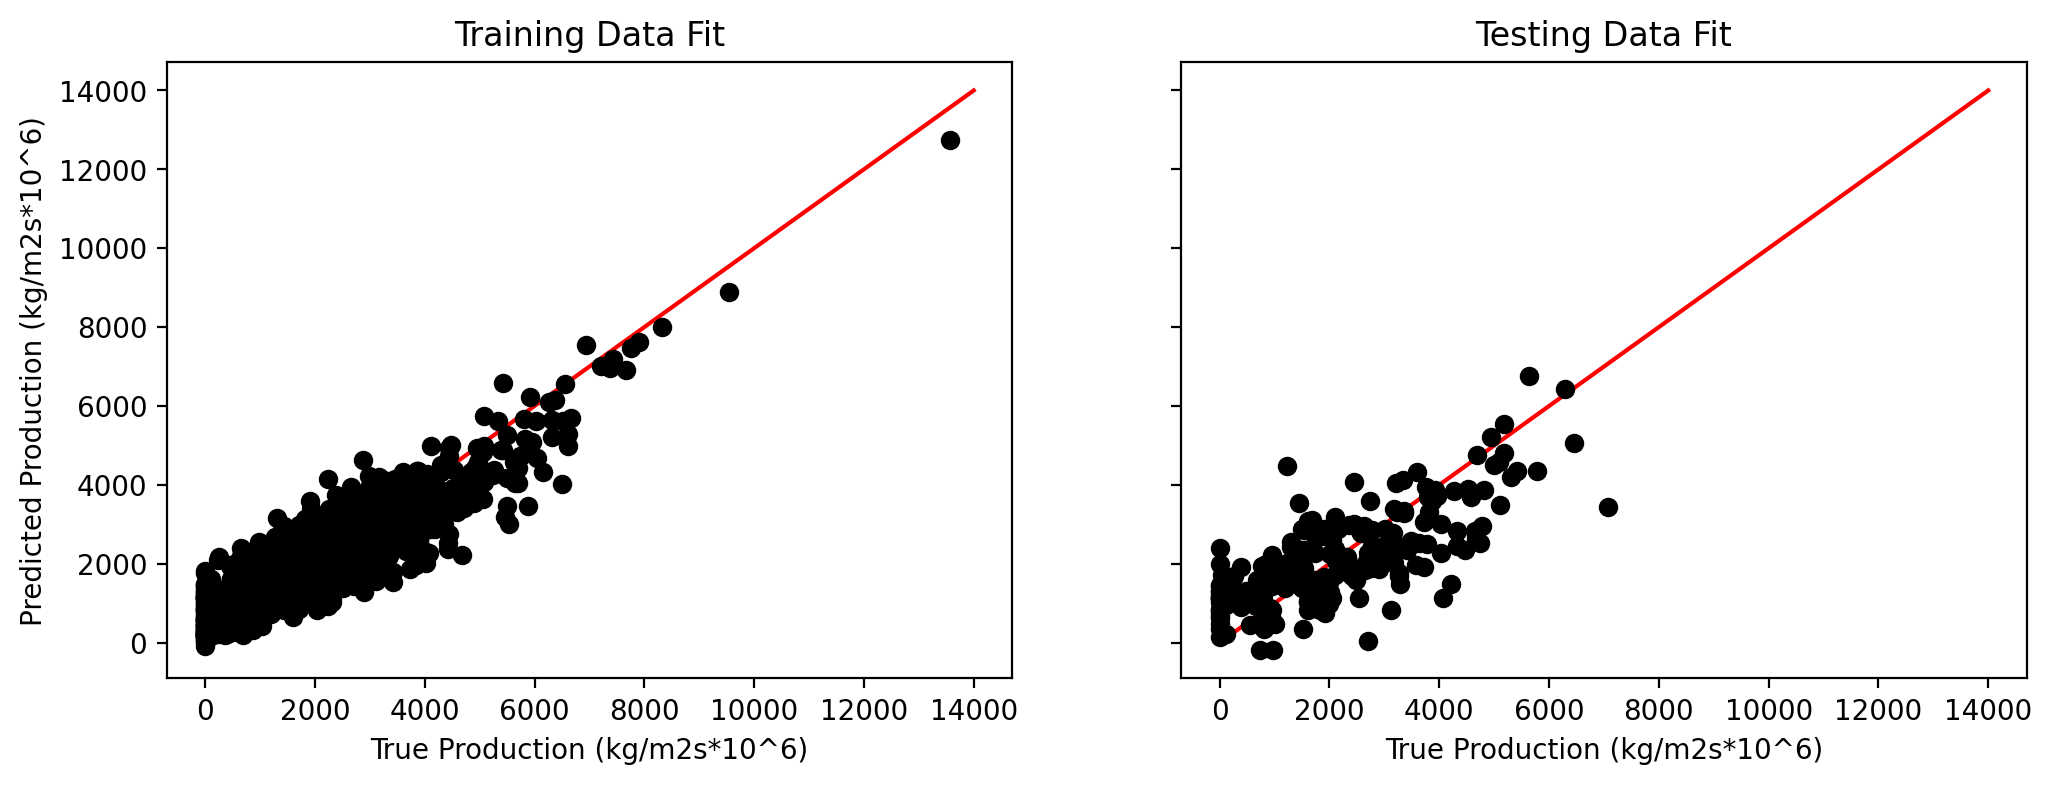

In [1543]:
#plot of data truth vs prediction for the training data & testing data
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].plot([0,14000],[0,14000],'r-') #1:1 line
ax[0].plot(y_train, test_model.predict(X_train), 'ko',label='Original Model')    #for original model

ax[1].plot([0,14000],[0,14000],'r-') #1:1 line
ax[1].plot(y_test, test_model.predict(X_test), 'ko',label='Original Model')    #for original model

#set axes labels
ax[0].set_title('Training Data Fit')
ax[0].set_ylabel('Predicted Production (kg/m2s*10^6)')
ax[0].set_xlabel('True Production (kg/m2s*10^6)')

ax[1].set_title('Testing Data Fit')
ax[1].set_xlabel('True Production (kg/m2s*10^6)')


We can double check whether our model hyperparameters are good by performing some hyperparameter tuning. Here we vary the hyperparameters within a range and calculate which has the lowest error.

In [1545]:
# tune hyperparameters

param_grid = {
    'n_estimators': [50, 100,250, 500], #we set a range of values for each hyperparameter to compare which results in the lowest error
    'max_depth': [1, 2, 3,5, 10],
    'learning_rate': [0.01,0.1,0.15,0.2,0.3]
}

grid_search = GridSearchCV(GradientBoostingRegressor(),
                           param_grid=param_grid, n_jobs=-1) # we create a grid of all possible hyperparameter combinations
grid_search.fit(X_train, y_train)    #this function checks which hyperparameter has the best result
print(grid_search.best_params_)

{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 50}


According to the hyperparamater tuning, the hyperparameter values we've selected are already the best options. So we will leave them as is and explore how to overfit!

### 4. Overfit Gradient Boosting

Overfit occurs when an overly complex model fits the training data extremely well-- capturing noise--and does not fit the testing data wll. In order to overfit, we will explore three hyperparameters: learning rate, number of estimators/trees, and maximum tree depth.

4a. First we will examine learning rate, or how quickly the model learns from each tree in the ensemble. We will iterate through many possible learning rates and see its effect on the loss function.

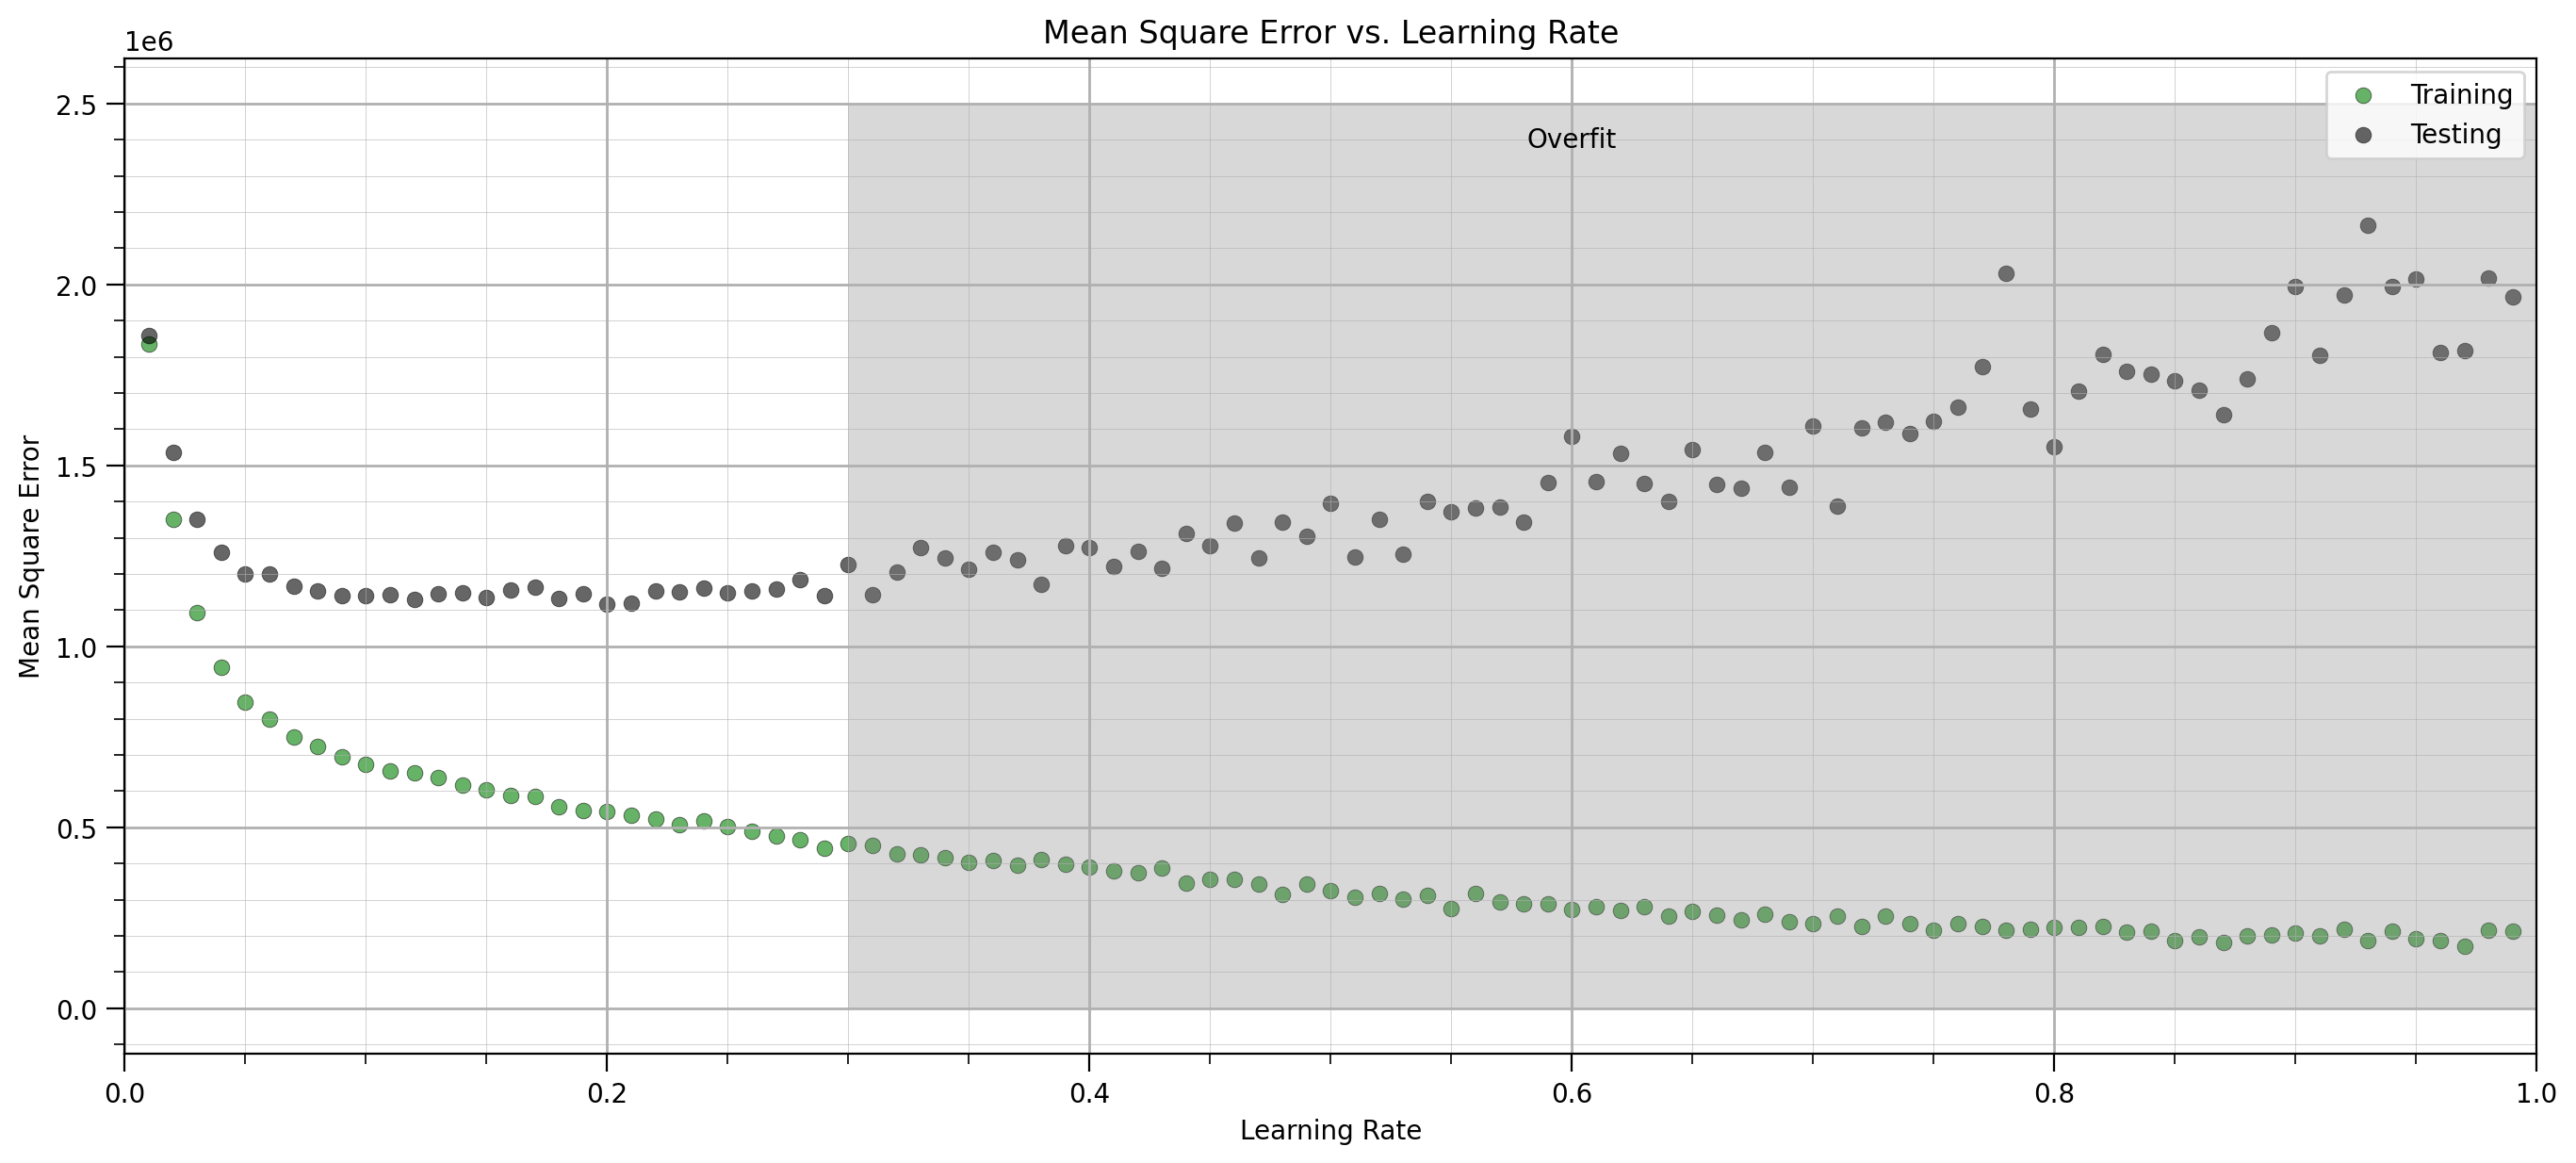

In [1493]:
#Plot error vs learning rate for both training and testing data

#The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Gradient_Boosting.ipynb from GeostatsGuy GitHub.

learning_rates = np.arange(0.01,1.0,0.01) #list of possible learning rates from 0.01 to 1.0
MSE1_list = []; MSE2_list = [];

#define the other parameters
params_lr = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'max_depth': 3,                                         # number of trees
    'n_estimators': 50,
}

index = 1
for learning_rate in learning_rates:                                  # loop over learning rate
    overfit_lr = GradientBoostingRegressor(learning_rate = learning_rate,**params_lr).fit(X = X_train, y = y_train) #create model
    y_train1_hat = overfit_lr.predict(X_train); MSE1_list.append(mean_squared_error(y_train,y_train1_hat)) #evaluate model with training data
    y_test1_hat = overfit_lr.predict(X_test); MSE2_list.append(mean_squared_error(y_test,y_test1_hat)) #evaluate model with testing data

    index = index + 1
    
plt.subplot(111)                                            # plot results for all cases
plt.scatter(learning_rates,MSE1_list,s=None,c='green',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6, #plot for training data
            linewidths=0.3,edgecolors="black",label = "Training")
plt.scatter(learning_rates,MSE2_list,s=None,c='black',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6, #plot for testing data
            linewidths=0.3,edgecolors="black",label = "Testing")

rect = patches.Rectangle((0.3, 0e6),0.8,2.5e6,linewidth=0,edgecolor=None,facecolor='gray',alpha=0.3) #highlight overfit region
plt.gca().add_patch(rect)
plt.text(0.6,2.4e6, "Overfit", ha='center',va='center',fontsize=10,color='black') #annotate overfit region

plt.title('Mean Square Error vs. Learning Rate'); plt.xlabel('Learning Rate'); plt.ylabel('Mean Square Error')
plt.xlim(0.0,1.0); plt.legend(loc='upper right'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Here we see that using a higher learning rate, a fast-learning model, reduces the error in the training data. However, a learning rate greater than 0.3 causes error in the testing data to increase. This region where the training error is still decreasing but the testing error is increasing, is where we see overfit.

We can retrain a model using this fast learning rate of 1.0 and see how it influences our result:

In [1548]:
#set hyperparameters
params_lr = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'max_depth': 3,                                        # maximum depth per tree
    'n_estimators': 50,    #number of trees
    'learning_rate': 1.0, # Fast learning rate
}

overfit_lr = GradientBoostingRegressor(**params_lr)  #instantiate model
overfit_lr.fit(X_train,y_train)     #fit model to training data
ypred = overfit_lr.predict(X_test)  #predict using testing data


Now let's visualize our predictions using the high learning rate vs the low learning rate from our earlier model:

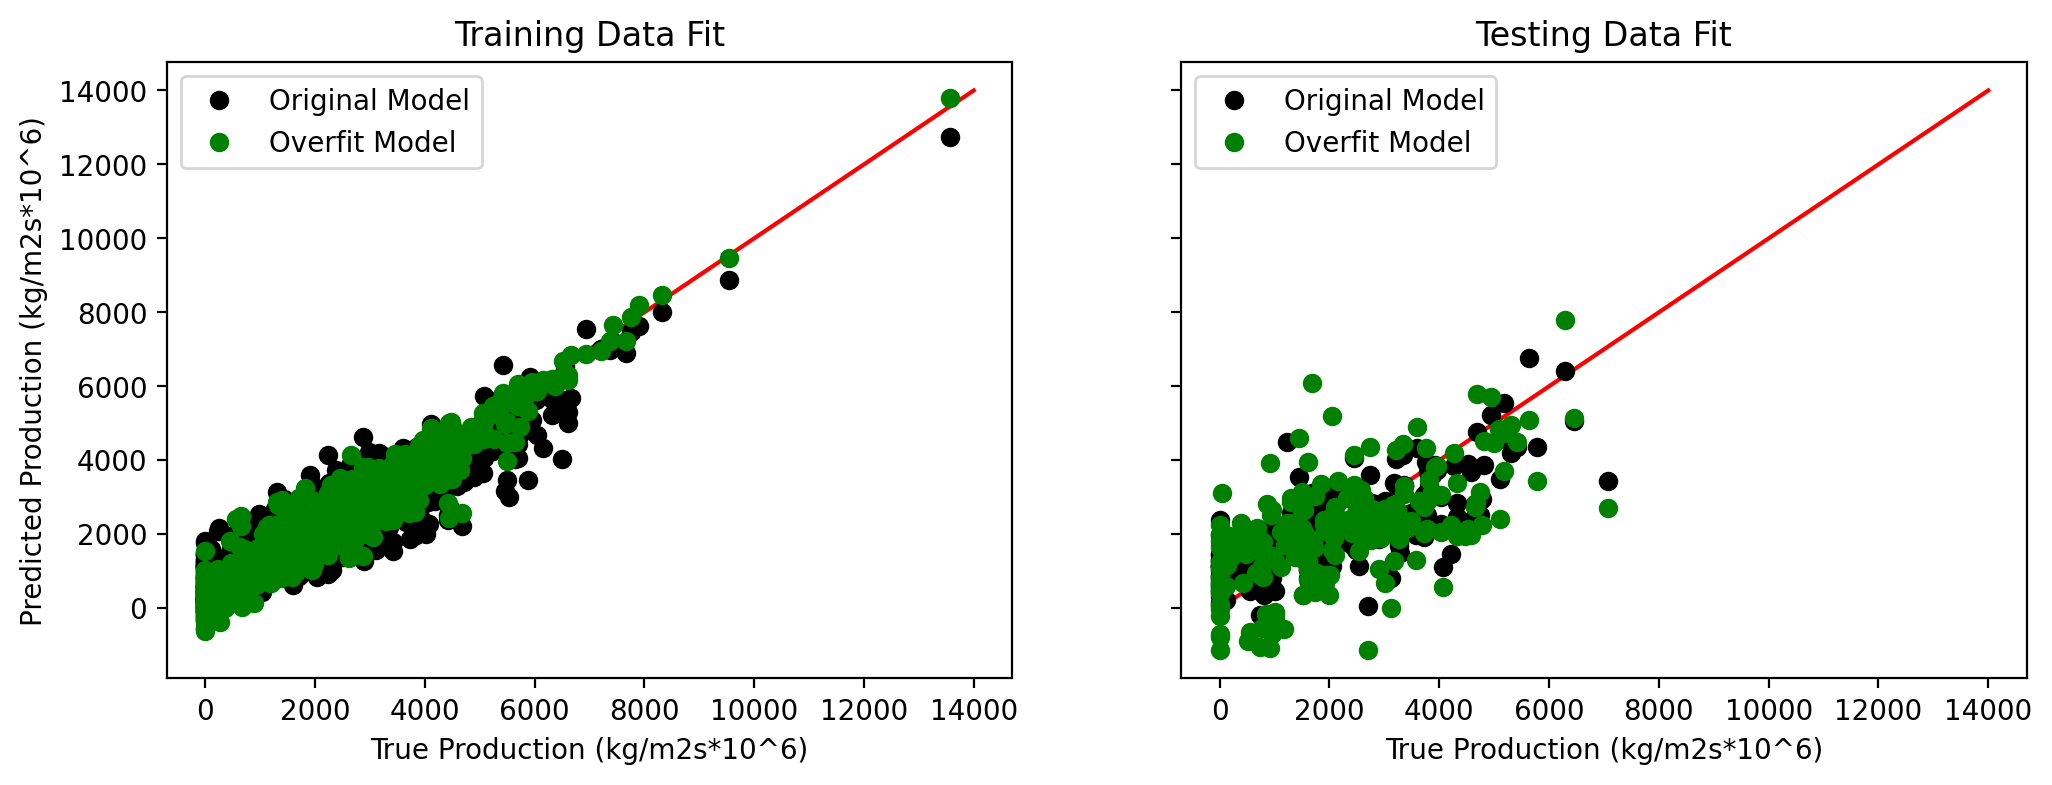

In [1552]:
#plot of data truth vs prediction for the training data & testing data
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].plot([0,14000],[0,14000],'r-') #1:1 line
ax[0].plot(y_train, test_model.predict(X_train), 'ko',label='Original Model')    #for original model
ax[0].plot(y_train, overfit_lr.predict(X_train), 'go',label='Overfit Model') #for overfit model

ax[1].plot([0,14000],[0,14000],'r-') #1:1 line
ax[1].plot(y_test, test_model.predict(X_test), 'ko',label='Original Model')    #for original model
ax[1].plot(y_test, overfit_lr.predict(X_test), 'go',label='Overfit Model') #for overfit model

#set axes labels
ax[0].set_title('Training Data Fit')
ax[0].set_ylabel('Predicted Production (kg/m2s*10^6)')
ax[0].set_xlabel('True Production (kg/m2s*10^6)')
ax[0].legend()

ax[1].set_title('Testing Data Fit')
ax[1].set_xlabel('True Production (kg/m2s*10^6)')
ax[1].legend()

The overfit model fits the training data better than the original model did. While the overfit model does have a worse performance with the testing data, it doesn't look that much worse than the original model. Here are the MSE scores for both models:

In [1505]:
mse_lr = mean_squared_error(y_test, overfit_lr.predict(X_test))
mse_test = mean_squared_error(y_test, test_model.predict(X_test))
lr_percent = mse_lr/mse_test *100

print("The mean squared error (MSE) on overfit model: {:.4f}".format(mse_lr))
print("The mean squared error (MSE) on original model: {:.4f}".format(mse_test))
print("The Overfit model MSE is greater than the original model MSE by {:.4f}%".format(lr_percent))

The mean squared error (MSE) on overfit model: 1807298.9305
The mean squared error (MSE) on original model: 1126269.7745
The Overfit model MSE is greater than the original model MSE by 160.4677%


4b. Now let's keep our fast learning rate and also look at the influence of the number of trees on model performance:

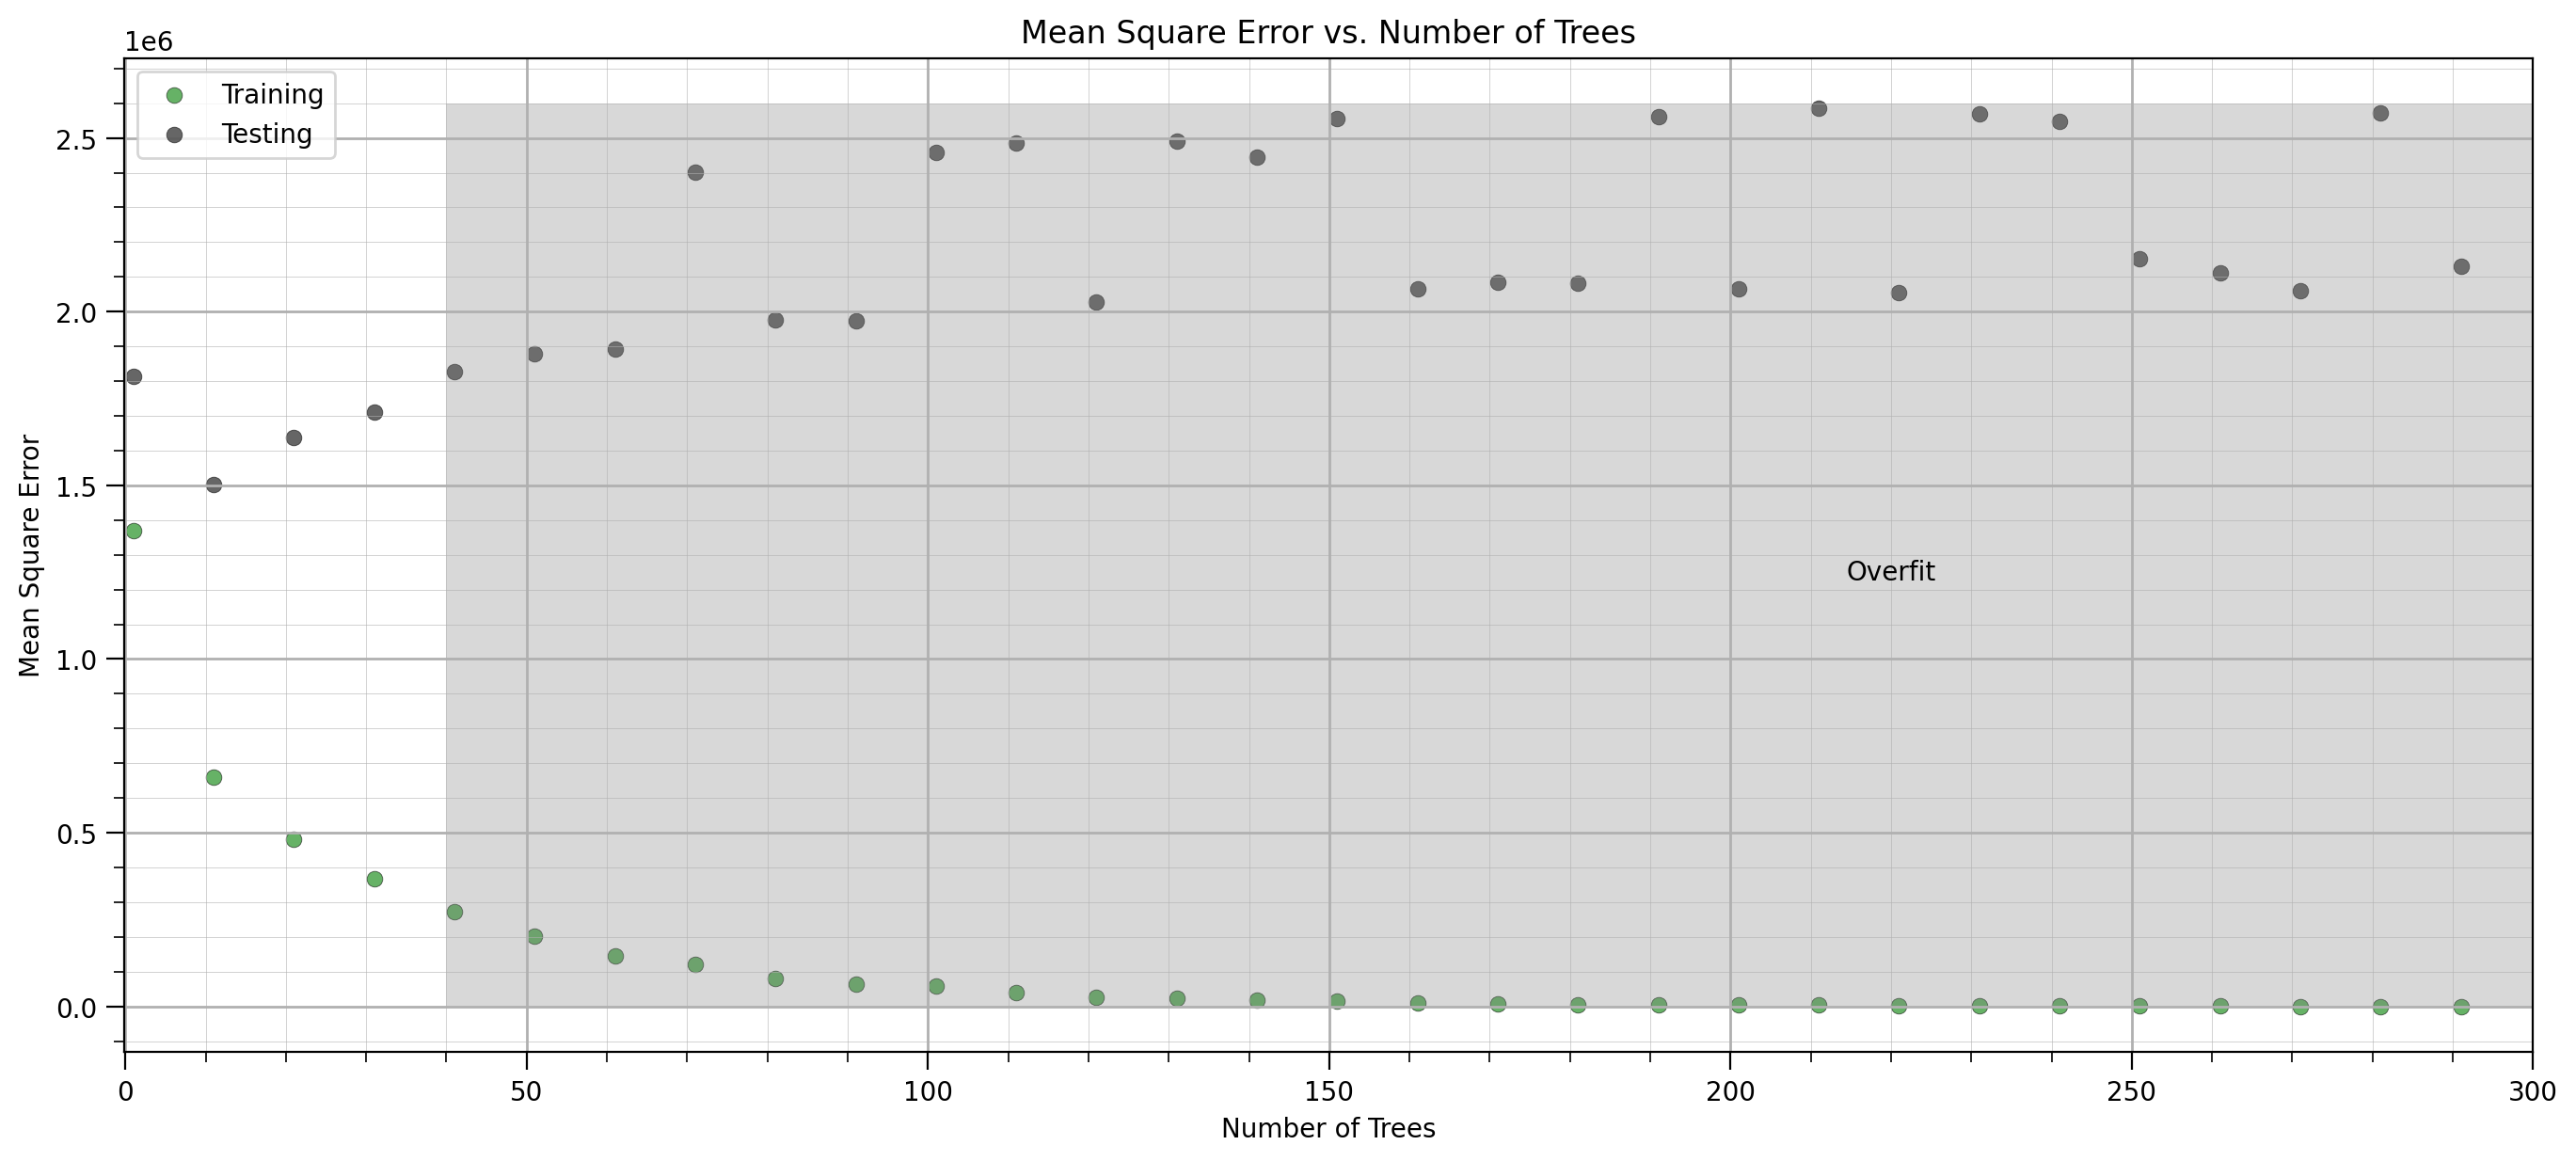

In [1554]:
#Plot error vs number of trees

#The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Gradient_Boosting.ipynb from GeostatsGuy GitHub.

estimators = np.arange(1,300,10) #list of possible n_estimators from 1 to 300
MSE3_list = []; MSE4_list = []; 


tree_params = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'max_depth': 3,                                         # depth of trees
    'learning_rate': 1.0,    #learning rate
}


index = 1
for n_estimators in estimators:                                  # loop over number of trees
    overfit_tree = GradientBoostingRegressor(n_estimators = n_estimators,**tree_params).fit(X = X_train, y = y_train) #create model
    y_train1_hat = overfit_tree.predict(X_train); MSE3_list.append(mean_squared_error(y_train,y_train1_hat)) #evaluate model with training data
    y_test1_hat = overfit_tree.predict(X_test); MSE4_list.append(mean_squared_error(y_test,y_test1_hat)) #evaluate model with testing data
    
    index = index + 1
    
plt.subplot(111)                                            # plot results for all cases
plt.scatter(estimators,MSE3_list,s=None,c='green',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6, #for training data
            linewidths=0.3,edgecolors="black",label = "Training")

plt.scatter(estimators,MSE4_list,s=None,c='black',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6, #for testing data
            linewidths=0.3,edgecolors="black",label = "Testing")

rect = patches.Rectangle((40, 0e6),260,2.6e6,linewidth=0,edgecolor=None,facecolor='gray',alpha=0.3) #highlight overfit region
plt.gca().add_patch(rect)
plt.text(220,1.25e6, "Overfit", ha='center',va='center',fontsize=10,color='black') #annotate overfit region

plt.title('Mean Square Error vs. Number of Trees'); plt.xlabel('Number of Trees'); plt.ylabel('Mean Square Error')
plt.xlim(-0.1,300.0); plt.legend(loc='upper left'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Here we see that using a larger ensemble of trees reduces the error in the training data to nearly zero! However the testing data has the lowest error at only 10 trees and error increases with the addition of more trees to the ensemble. We will use a value of 250 for n_estimators and see how this effects our model:

In [1556]:
#set hyperparameters
tree_params = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'max_depth': 3,                                        # maximum depth per tree
    'n_estimators': 250,    #large number of trees
    'learning_rate': 1.0, # fast learning rate
}

overfit_tree = GradientBoostingRegressor(**tree_params)  #instantiate model
overfit_tree.fit(X_train,y_train)     #fit model to training data
ypred = overfit_tree.predict(X_test)  #predict using testing data


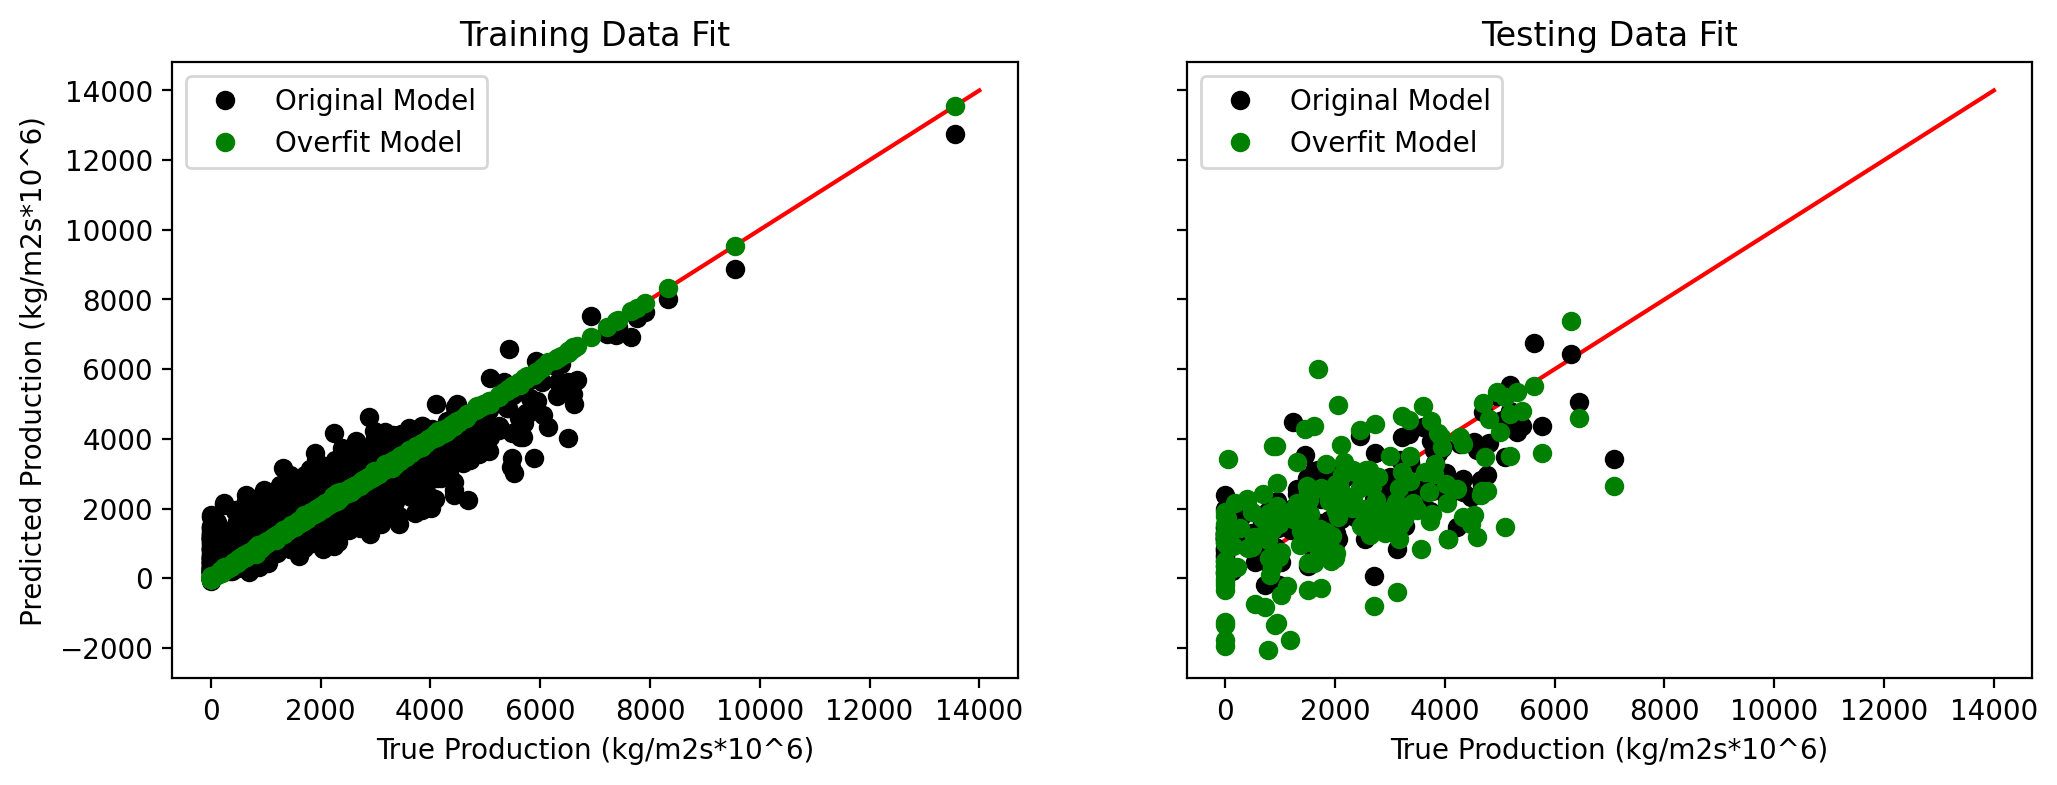

In [1558]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].plot([0,14000],[0,14000],'r-') #1:1 line
ax[0].plot(y_train, test_model.predict(X_train), 'ko',label='Original Model')
ax[0].plot(y_train, overfit_tree.predict(X_train), 'go',label='Overfit Model') #training data truth vs prediction

ax[1].plot([0,14000],[0,14000],'r-') #1:1 line
ax[1].plot(y_test, test_model.predict(X_test), 'ko',label='Original Model')
ax[1].plot(y_test, overfit_tree.predict(X_test), 'go',label='Overfit Model') #testing data truth vs prediction

#set axes labels
ax[0].set_title('Training Data Fit')
ax[0].set_ylabel('Predicted Production (kg/m2s*10^6)')
ax[0].set_xlabel('True Production (kg/m2s*10^6)')
ax[0].legend()

ax[1].set_title('Testing Data Fit')
ax[1].set_xlabel('True Production (kg/m2s*10^6)')
ax[1].legend()

Now we can see that the combination of fast learning and large number of trees results in nearly perfect fit of the training data, but worse fit of the testing data. We will once again check the MSE performance of this overfit model relative to our original model in section 3:

In [1560]:
mse_tree = mean_squared_error(y_test, overfit_tree.predict(X_test))
mse_test = mean_squared_error(y_test, test_model.predict(X_test))
tree_percent = mse_tree/mse_test *100

print("The mean squared error (MSE) on overfit model: {:.4f}".format(mse_tree))
print("The mean squared error (MSE) on original model: {:.4f}".format(mse_test))
print("The Overfit model MSE is greater than the original model MSE by {:.4f}%".format(tree_percent))

The mean squared error (MSE) on overfit model: 2065930.9009
The mean squared error (MSE) on original model: 1126269.7745
The Overfit model MSE is greater than the original model MSE by 183.4313%


4c. Finally, we will look at the max_depth hyperparameter:

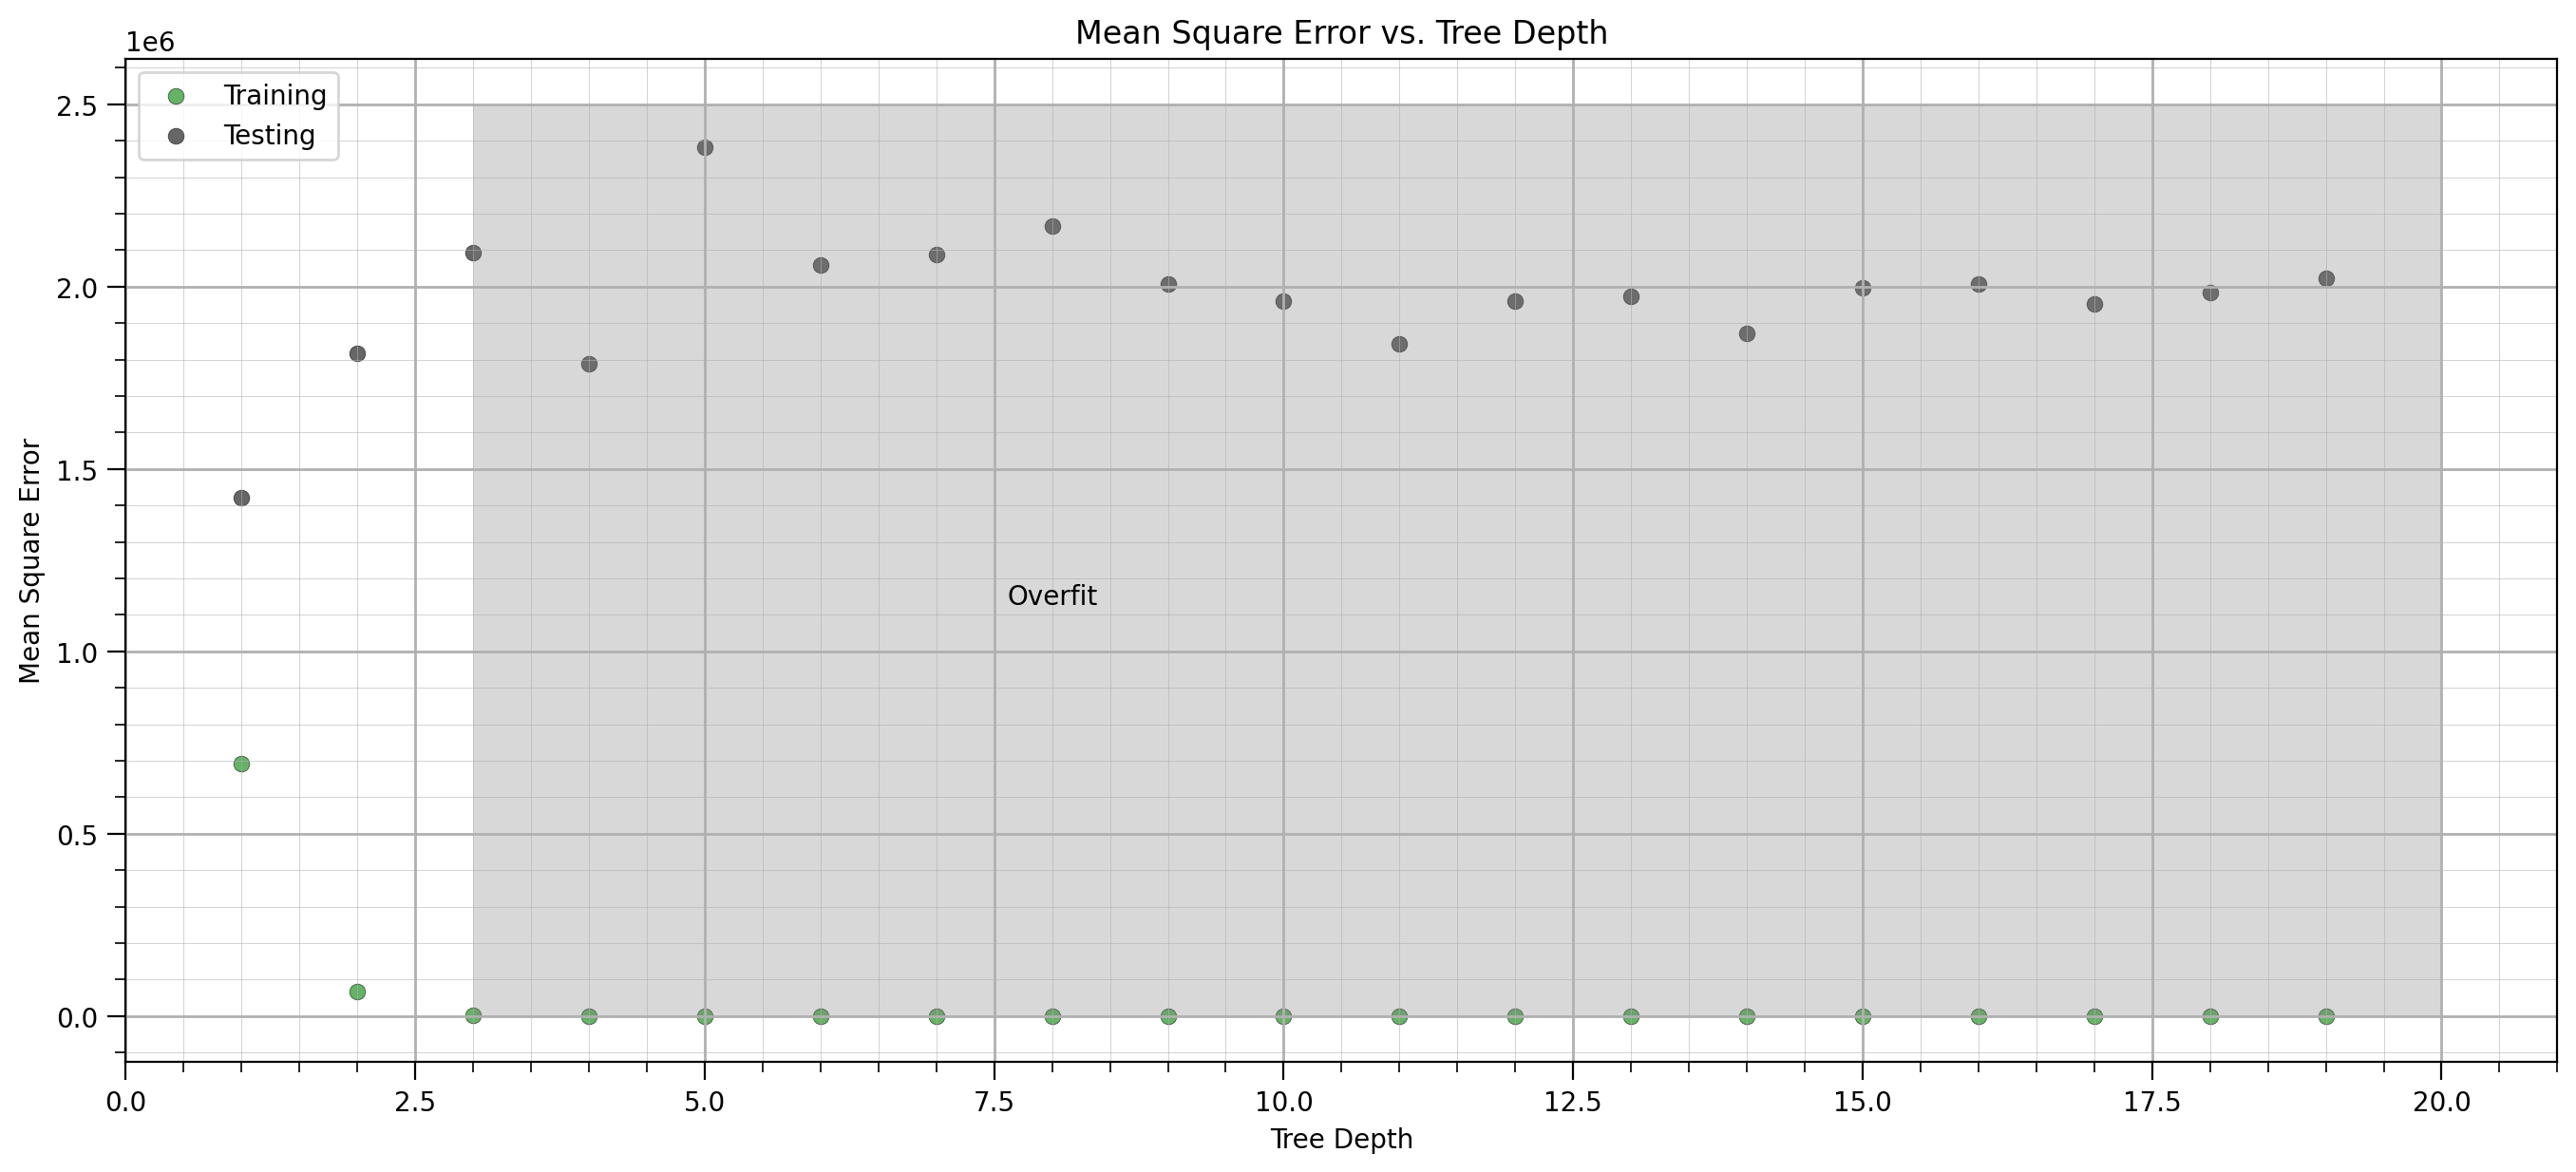

In [1530]:
max_depths = np.arange(1,20,1) #range of depths from 1 to 20
max_features = 1
MSE5_list = []; MSE6_list = [] 

params_dep = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'learning_rate': 1.0, #fast learning rate
    'n_estimators':250
}

index = 1
for max_depth in max_depths:                                  # loop over tree depth options
    boosting_model1 = GradientBoostingRegressor(max_depth=int(max_depth),**params_dep).fit(X = X_train, y = y_train) #create model
    y_train1_hat = boosting_model1.predict(X_train); MSE5_list.append(mean_squared_error(y_train,y_train1_hat))  #evaluate model with training data
    y_test1_hat = boosting_model1.predict(X_test); MSE6_list.append(mean_squared_error(y_test,y_test1_hat))#evaluate model with testing data
    index = index + 1
    
plt.subplot(111)                                            # plot jackknife results for all cases
plt.scatter(max_depths,MSE5_list,s=None,c='green',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6,
            linewidths=0.3,edgecolors="black",label = "Training")
plt.scatter(max_depths,MSE6_list,s=None,c='black',marker=None,cmap=None,norm=None,vmin=None,vmax=None,alpha=0.6,
            linewidths=0.3,edgecolors="black",label = "Testing")

rect = patches.Rectangle((3, 0e6),17,2.5e6,linewidth=0,edgecolor=None,facecolor='gray',alpha=0.3) #highlight overfit region
plt.gca().add_patch(rect)
plt.text(8,1.15e6, "Overfit", ha='center',va='center',fontsize=10,color='black') #annotate overfit region

plt.title('Mean Square Error vs. Tree Depth'); plt.xlabel('Tree Depth'); plt.ylabel('Mean Square Error')
plt.xlim(0,21); plt.legend(loc='upper left'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Depths greater than 3 actually have no further effect on the training data, while depths greater thatn 6 have little effect on the testing error. The highest mismatch between training and testing data occurs at a tree depth of ~5 in this case.

One last time, let's retrain our model with a max_depth of 5 and see how this affects our results:

In [1562]:
#set hyperparameters
params_dep = {
    'loss': 'squared_error',                                           # L2 Norm - least squares
    'max_depth': 5,                                        # maximum depth per tree
    'n_estimators': 250,    #number of trees
    'learning_rate': 1.0, # Fast learning rate
}

overfit_depth = GradientBoostingRegressor(**params_dep)  #instantiate model
overfit_depth.fit(X_train,y_train)     #fit model to training data
ypred = overfit_depth.predict(X_test)  #predict using testing data


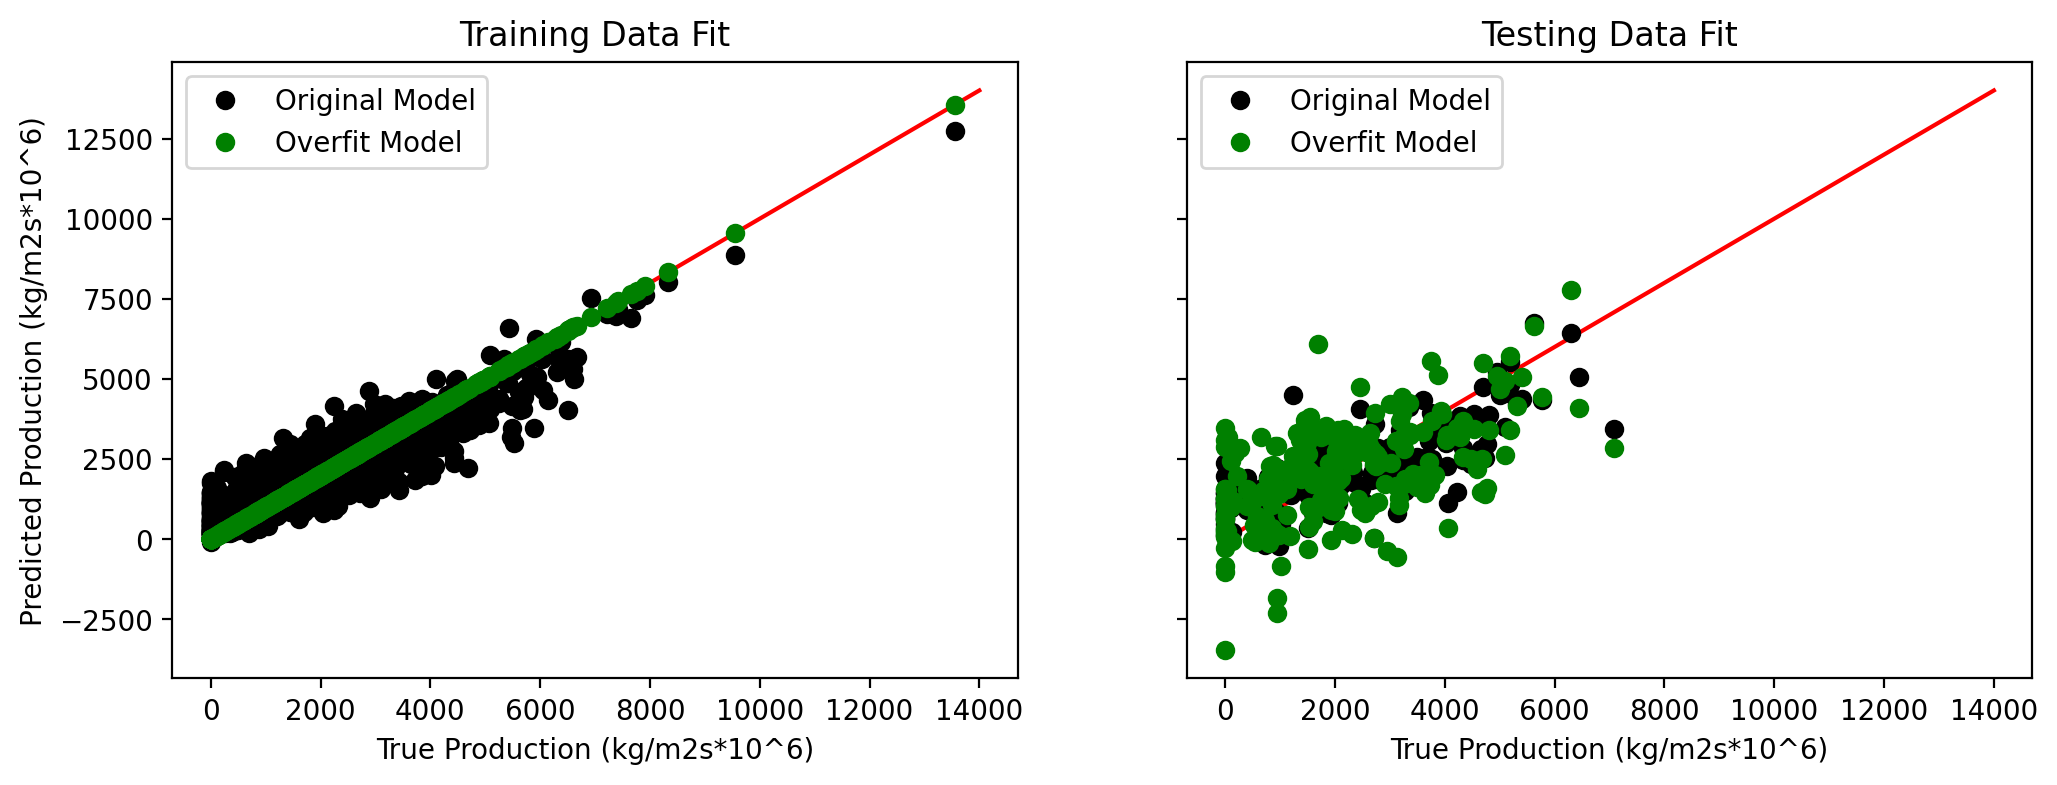

In [1564]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
ax[0].plot([0,14000],[0,14000],'r-') #1:1 line
ax[0].plot(y_train, test_model.predict(X_train), 'ko',label='Original Model')
ax[0].plot(y_train, overfit_depth.predict(X_train), 'go',label='Overfit Model') #training data truth vs prediction

ax[1].plot([0,14000],[0,14000],'r-') #1:1 line
ax[1].plot(y_test, test_model.predict(X_test), 'ko',label='Original Model')
ax[1].plot(y_test, overfit_depth.predict(X_test), 'go',label='Overfit Model') #testing data truth vs prediction

#set axes labels
ax[0].set_title('Training Data Fit')
ax[0].set_ylabel('Predicted Production (kg/m2s*10^6)')
ax[0].set_xlabel('True Production (kg/m2s*10^6)')
ax[0].legend()

ax[1].set_title('Testing Data Fit')
ax[1].set_xlabel('True Production (kg/m2s*10^6)')
ax[1].legend()

In [1566]:
mse_depth = mean_squared_error(y_test, overfit_depth.predict(X_test))
mse_test = mean_squared_error(y_test, test_model.predict(X_test))
depth_percent = mse_depth/mse_test *100

print("The mean squared error (MSE) on overfit model: {:.4f}".format(mse_depth))
print("The mean squared error (MSE) on original model: {:.4f}".format(mse_test))
print("The Overfit model test MSE is greater than the original model test MSE by {:.4f}%".format(depth_percent))


The mean squared error (MSE) on overfit model: 2236339.7563
The mean squared error (MSE) on original model: 1126269.7745
The Overfit model test MSE is greater than the original model test MSE by 198.5616%


We have officially made our worst-fitting model :)

### 5. Conclusions

We found that by examining the hyperparameter values relative to the error, we could find values that resulted in a decrease in training error to zero, but that increased the error on the testing data. When this happens, we know we have too much model complexity.

We achieved our overfit model by adjusting 3 hyperparameters:

1. Learning Rate: By using a high learning rate, we are telling the model to learn more from each split. This is bad when each split may not be very good and our model may jump too fast and miss an optimal solution.

2. Number of Trees: Gradient boosting takes the average of all trees in the ensemble. Therefore, if we include a lot of poorly fit trees, we can cause overfit to occur.

3. Maximum tree depth: Tree depth allows for many splits to occur within a tree. When data is noisy, a high max_depth allows the tree to fit smaller patterns in the data and result in overfit.

Going forward, it is important to use slow learning in gradient boosting, and to perform hyperparameter tuning to select optimal values for your model.

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)